In [1]:
#!/usr/bin/env python
# coding: utf-8

import os, sys
import logging

import numpy as np
import h5netcdf

import xarray as xr
import xarray.ufuncs as xu
import xrft
import pandas as pd
from scipy.signal import convolve2d, detrend

from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy

plt.rc("figure", figsize=(12,10))
plt.rc("font", size=14)

from dask.distributed import Client, LocalCluster
#
# Initialisation d'un cluster de 32 coeurs
cluster = LocalCluster(processes=False, n_workers=1, threads_per_worker=8, silence_logs='error')
client = Client(cluster)
client

<Client: 'inproc://137.129.155.67/9554/1' processes=1 threads=8, memory=78.61 GiB>

In [2]:
day1 = '2009-08-21'
day2 = '2009-09-20'
specificDay = '2009-09-01T12'

In [7]:
year = 2009

indir_anom = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/RAW_ANOMALY/'

ds_u = xr.open_mfdataset(indir_anom + '/u/anom_u_brut_ERA5_3H*' + str(year) + '.nc', chunks = {'time' : 1}, parallel=True, concat_dim="level")
_ds_u = xr.open_mfdataset(indir_anom + '/u/anom_u_z850_brut_ERA5_3H*' + str(year) + '.nc', chunks = {'time' : 1}, parallel=True, concat_dim="level")
ds_u = xr.concat([ds_u.sel(level = 200), _ds_u], dim = "level")

ds_v = xr.open_mfdataset(indir_anom + '/v/anom_v_brut_ERA5_3H*' + str(year) + '.nc', chunks = {'time' : 1}, parallel=True, concat_dim="level")
_ds_v = xr.open_mfdataset(indir_anom + '/v/anom_v_z850_brut_ERA5_3H*' + str(year) + '.nc', chunks = {'time' : 1}, parallel=True, concat_dim="level")
ds_v = xr.concat([ds_v.sel(level = 200), _ds_v], dim = "level")

indir_data_FILTERED = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/FILTERED_ANOMALY/'
filenames = np.arange(2009,2010)

datasets = []
for f in filenames:
    ds = xr.open_mfdataset(indir_data_FILTERED + 'OLR/*CERES*' + str(f) + '*.nc', chunks={'time': 150})
    datasets.append(ds)
ds_anom_OLR = xr.concat(datasets, dim='time', coords='minimal', compat='override')
_ds_anom_OLR = ds_anom_OLR.assign_coords(lon=(((ds_anom_OLR.lon + 180) % 360) - 180)).sortby('lon')
_ds_anom_OLR = _ds_anom_OLR.sel(time= specificDay, lon = slice(-15,20))

datasets = []
for f in filenames:
    print(indir_data_FILTERED + 'TCWV/* ' + str(f) + '*.nc')
    ds = xr.open_mfdataset(indir_data_FILTERED + 'TCWV/*' + str(f) + '*.nc', chunks={'time': 150})
    datasets.append(ds)
ds_anom_TCWV = xr.concat(datasets, dim='time', coords='minimal', compat='override')
_ds_anom_TCWV = ds_anom_TCWV.assign_coords(lon=(((ds_anom_TCWV.lon + 180) % 360) - 180)).sortby('lon')
_ds_anom_TCWV = _ds_anom_TCWV.sel(time= specificDay, lon = slice(-15,20))
_ds_anom_TCWV

/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/FILTERED_ANOMALY/TCWV/* 2009*.nc


/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key

<xarray.Dataset>
Dimensions:      (lat: 321, lon: 141)
Coordinates:
    time         datetime64[ns] 2009-09-01T12:00:00
  * lat          (lat) float64 40.0 39.75 39.5 39.25 ... -39.5 -39.75 -40.0
  * lon          (lon) float32 -15.0 -14.75 -14.5 -14.25 ... 19.5 19.75 20.0
Data variables:
    TCWV_Kelvin  (lat, lon) float64 dask.array<chunksize=(321, 141), meta=np.ndarray>
    TCWV_Rossby  (lat, lon) float64 dask.array<chunksize=(321, 141), meta=np.ndarray>
    TCWV_MJO     (lat, lon) float64 dask.array<chunksize=(321, 141), meta=np.ndarray>
    TCWV_MRG     (lat, lon) float64 dask.array<chunksize=(321, 141), meta=np.ndarray>
    TCWV_EIG     (lat, lon) float64 dask.array<chunksize=(321, 141), meta=np.ndarray>
    TCWV_WIG     (lat, lon) float64 dask.array<chunksize=(321, 141), meta=np.ndarray>
    TCWV_TD      (lat, lon) float64 dask.array<chunksize=(321, 141), meta=np.ndarray>
    TCWV_LF      (lat, lon) float64 dask.array<chunksize=(321, 141), meta=np.ndarray>

In [10]:
ds = xr.merge([ds_u.sel(time = slice(day1, day2)),ds_v.sel(time = slice(day1, day2))])
ds = ds.assign_coords(longitude = (((ds.longitude + 180) % 360) - 180)).sortby('longitude')
ds = ds.isel(latitude = slice(0,None,4), longitude = slice(0,None,4)).sel(longitude = slice(-15,20), time= specificDay )
ds

/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key

<xarray.Dataset>
Dimensions:    (level: 2, longitude: 36, latitude: 81)
Coordinates:
  * level      (level) int32 200 850
  * longitude  (longitude) float32 -15.0 -14.0 -13.0 -12.0 ... 18.0 19.0 20.0
  * latitude   (latitude) float32 40.0 39.0 38.0 37.0 ... -38.0 -39.0 -40.0
    time       datetime64[ns] 2009-09-01T12:00:00
Data variables:
    u_ano      (latitude, longitude, level) float64 dask.array<chunksize=(81, 36, 1), meta=np.ndarray>
    v_ano      (latitude, longitude, level) float64 dask.array<chunksize=(81, 36, 1), meta=np.ndarray>

In [30]:
map_proj = ccrs.Mercator(central_longitude=0.0, 
                         min_latitude=0.0, 
                         max_latitude=30.0,
                         globe=None)


# Vent avec l'onde de Kelvin

## à 850 hPA

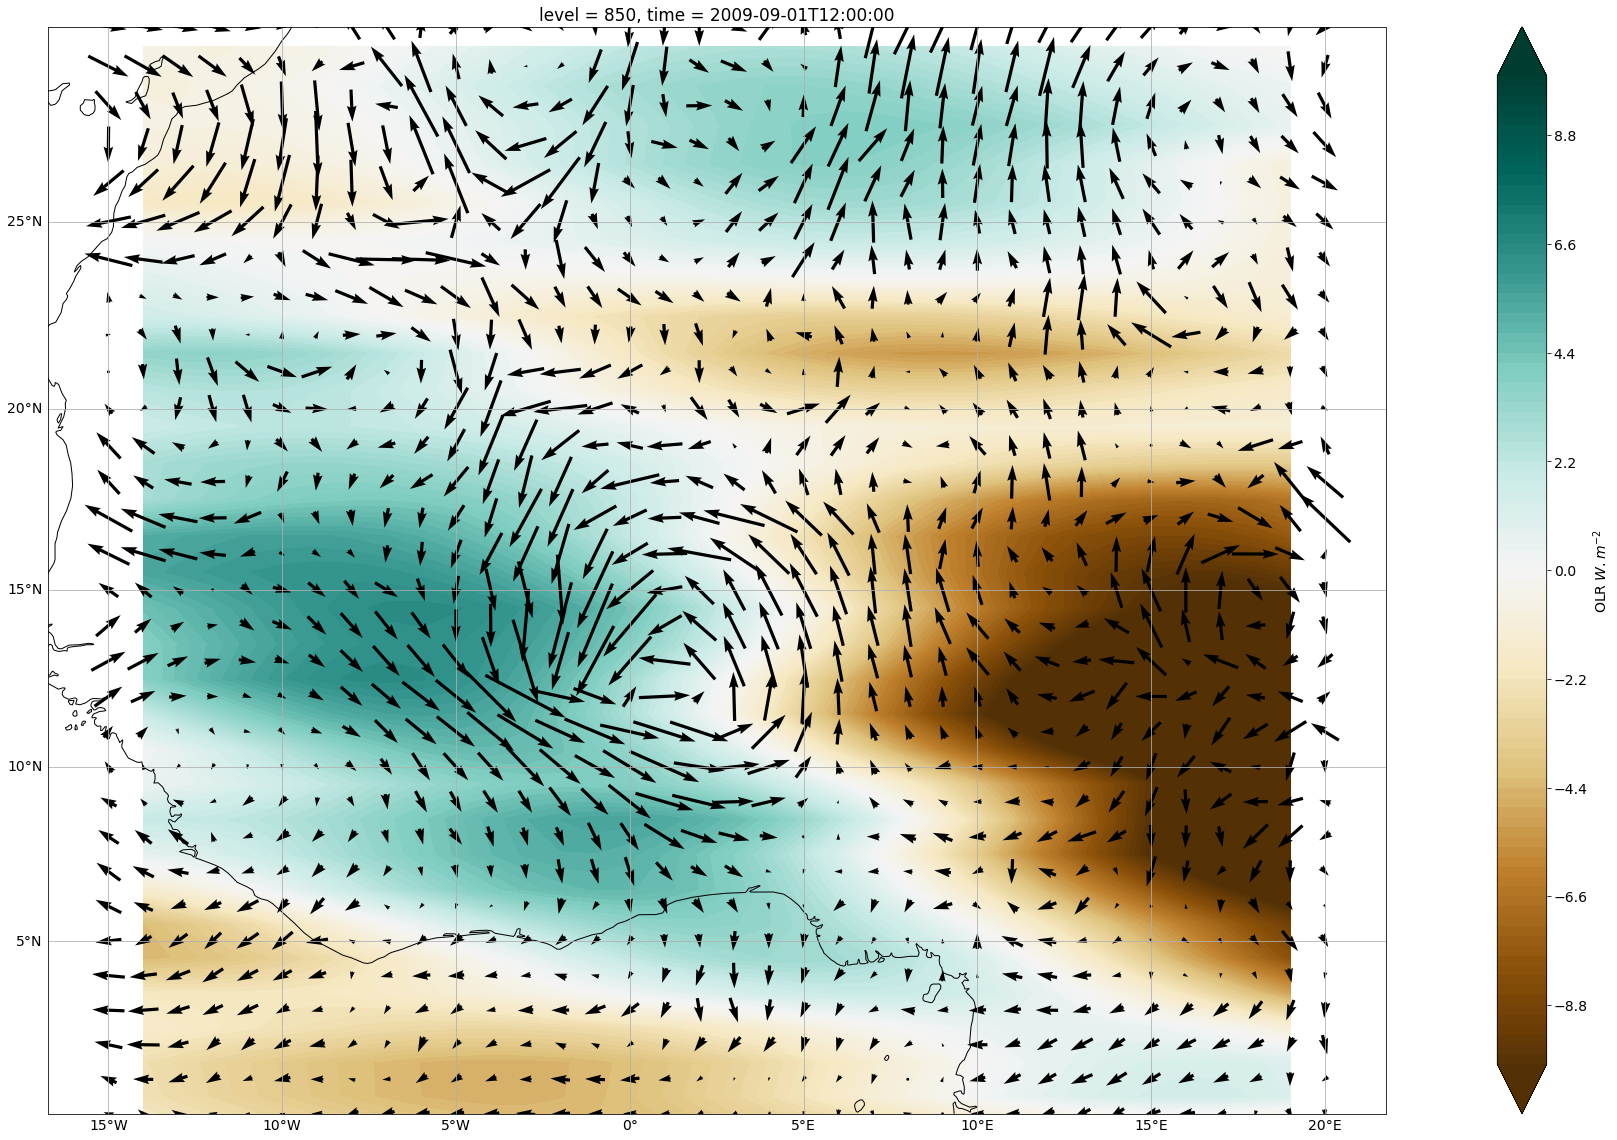

In [31]:
# plt.rc("figure", figsize=(20,14))
cmap ='BrBG'
vmin, vmax = -10, +10

#####################################################################################
colorbar = {'label': 'OLR $W.m^{-2}$',
            'orientation': 'vertical' ,
            'extend' : 'both'}

fig, axis = plt.subplots( 1, 1, 
    figsize=(40,20), subplot_kw={'projection': map_proj})

_ds_anom_OLR['OLR_Kelvin'].plot.contourf(ax=axis, levels = 101, vmin = vmin, vmax = vmax,
                    transform=ccrs.PlateCarree(),
                    cmap=cmap ,
                    cbar_kwargs=colorbar)


ds.isel(level=1).plot.quiver(x="longitude", y="latitude", u="u_ano", v="v_ano",
                                    transform=ccrs.PlateCarree(), ax=axis, 
                                    scale = 200)

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.show()

## à 200 hPA

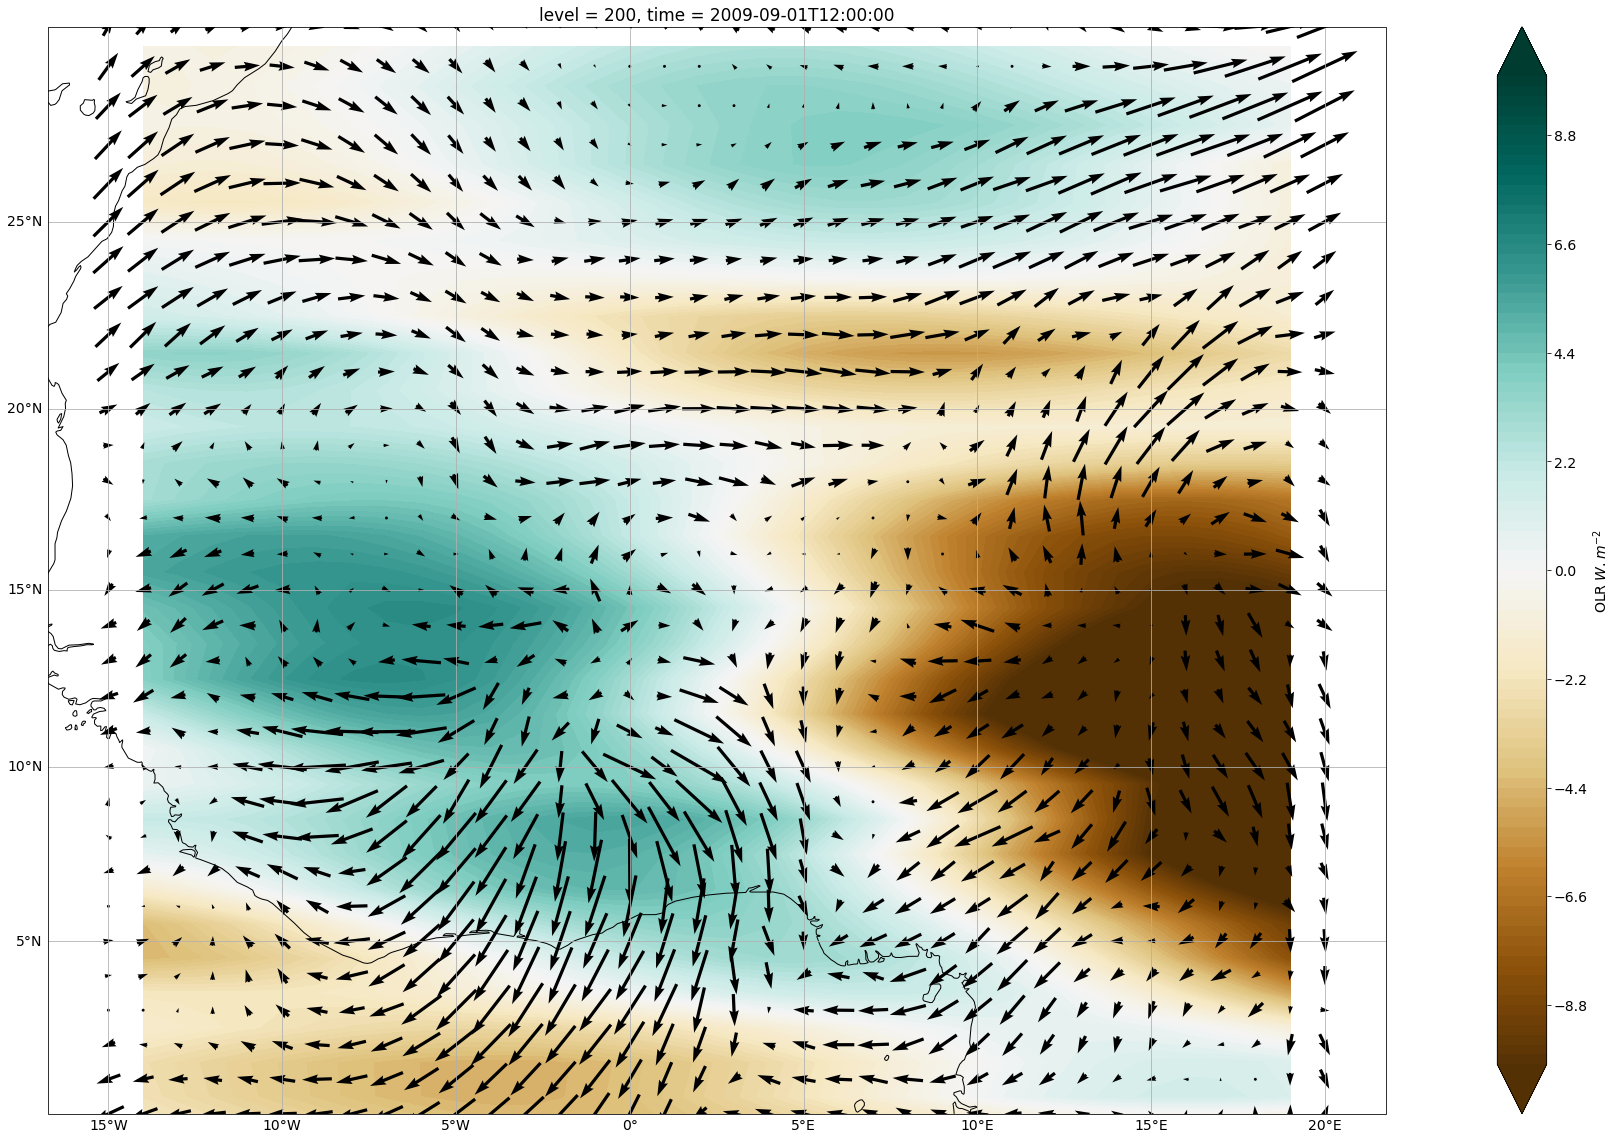

In [32]:
#####################################################################################
colorbar = {'label': 'OLR $W.m^{-2}$',
            'orientation': 'vertical' ,
            'extend' : 'both'}

fig, axis = plt.subplots( 1, 1, 
    figsize=(40,20), subplot_kw={'projection': map_proj})

_ds_anom_OLR['OLR_Kelvin'].plot.contourf(ax=axis, levels = 101, vmin = vmin, vmax = vmax,
                    transform=ccrs.PlateCarree(),
                    cmap=cmap ,
                    cbar_kwargs=colorbar)


ds.isel(level=0).plot.quiver(x="longitude", y="latitude", u="u_ano", v="v_ano",
                                    transform=ccrs.PlateCarree(), ax=axis, 
                                    scale = 400)

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.show()

# Vent avec l'onde de Rossby 

## à 850 hPa

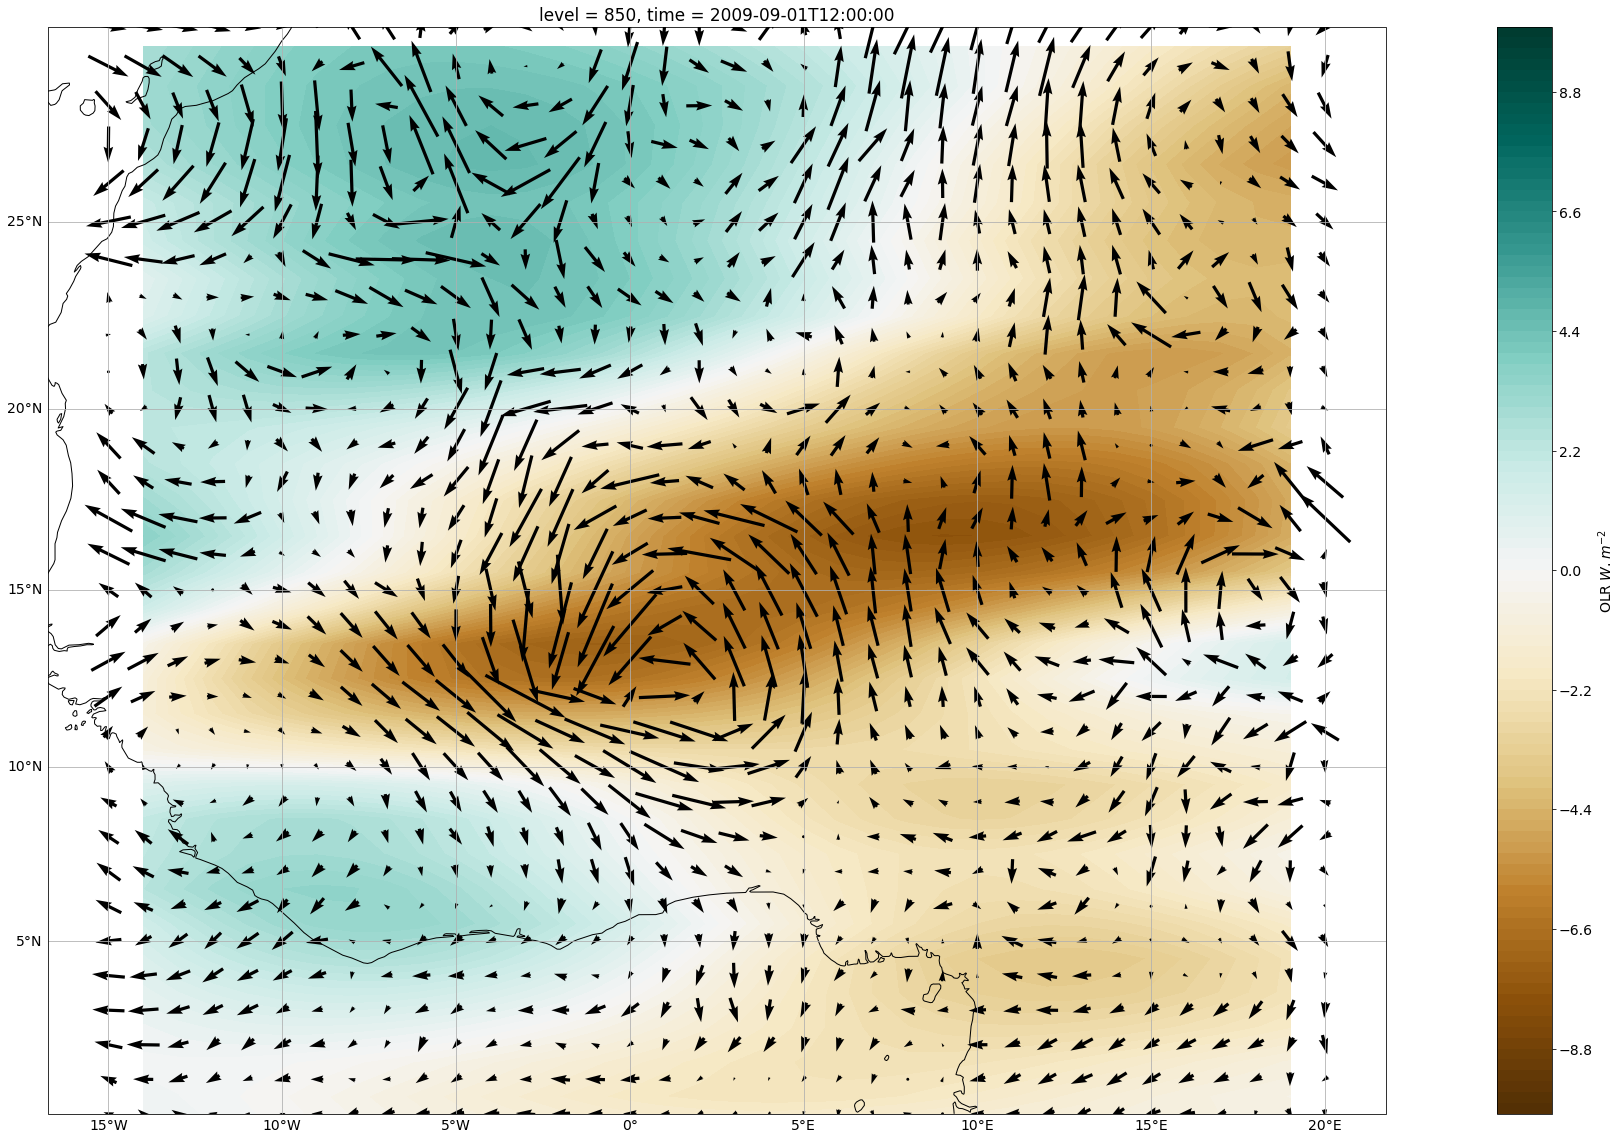

In [33]:
#####################################################################################
colorbar = {'label': 'OLR $W.m^{-2}$',
            'orientation': 'vertical' ,
            'extend' : 'both'}

fig, axis = plt.subplots( 1, 1, 
    figsize=(40,20), subplot_kw={'projection': map_proj})

_ds_anom_OLR['OLR_Rossby'].plot.contourf(ax=axis, levels = 101, vmin = vmin, vmax = vmax,
                    transform=ccrs.PlateCarree(),
                    cmap=cmap ,
                    cbar_kwargs=colorbar)


ds.isel(level=1).plot.quiver(x="longitude", y="latitude", u="u_ano", v="v_ano",
                                    transform=ccrs.PlateCarree(), ax=axis, 
                                    scale = 200)

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.show()

## à 200 hPa

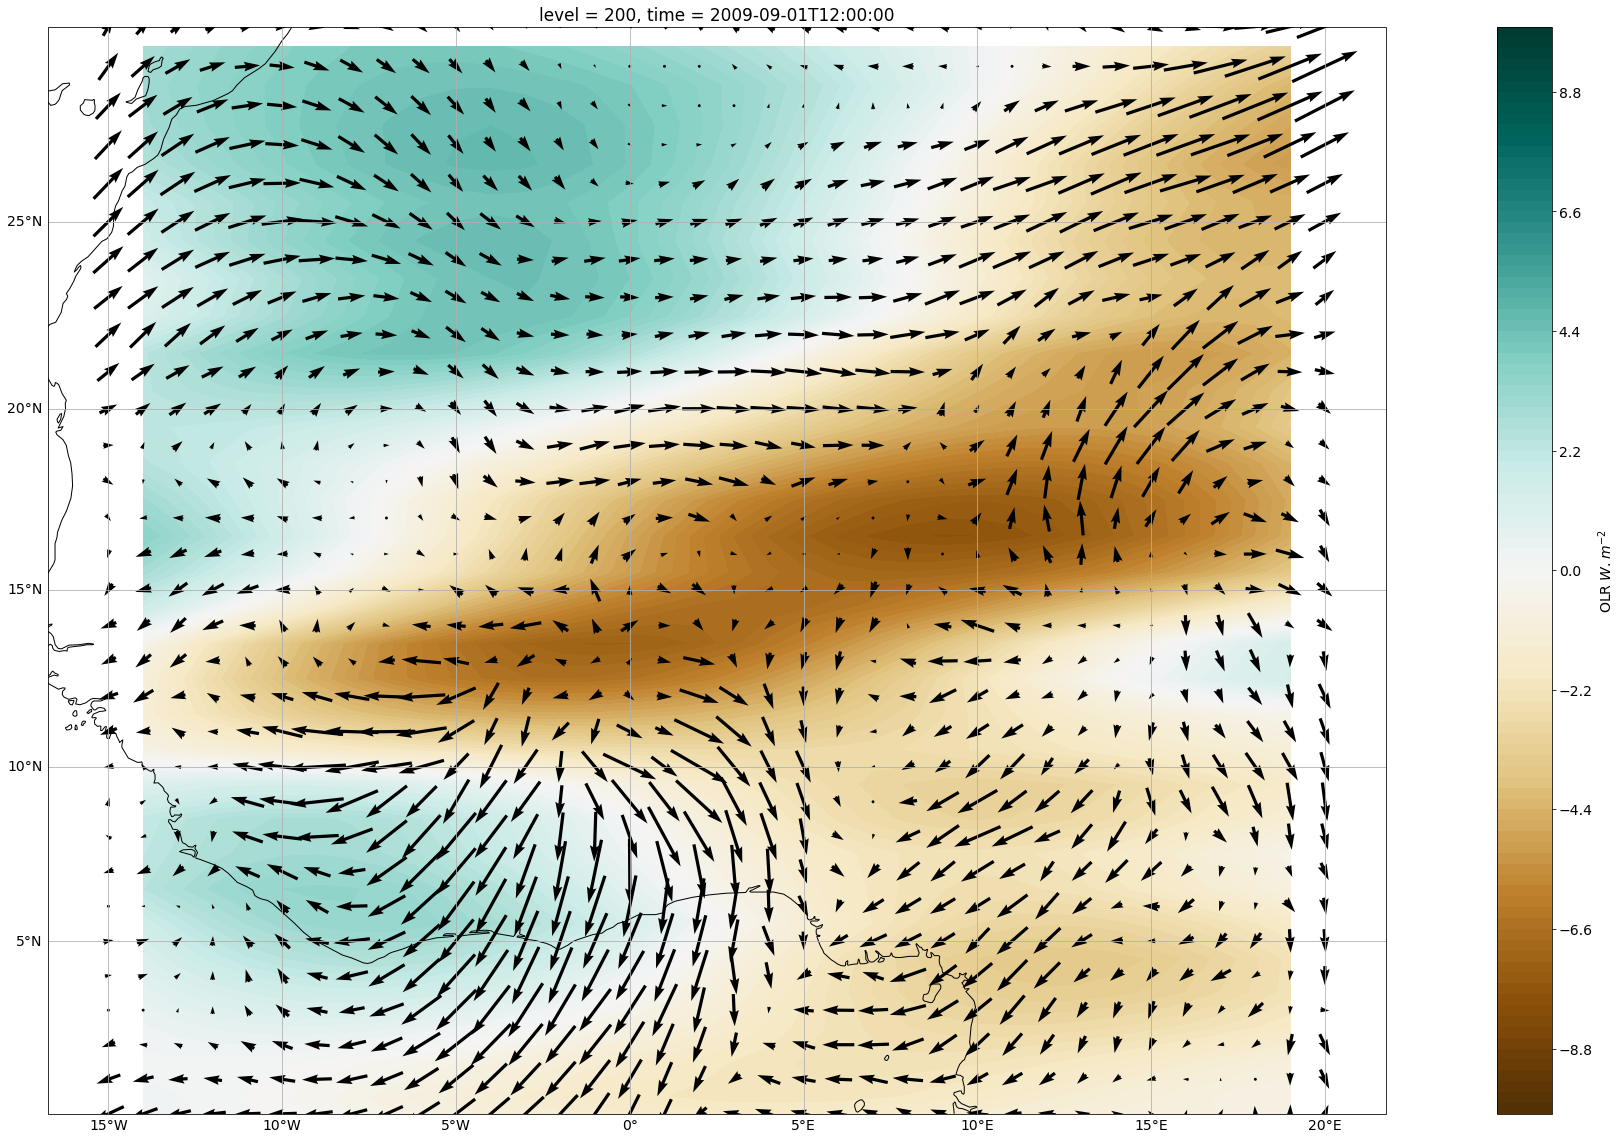

In [34]:
#####################################################################################
colorbar = {'label': 'OLR $W.m^{-2}$',
            'orientation': 'vertical' ,
            'extend' : 'both'}

fig, axis = plt.subplots( 1, 1, 
    figsize=(40,20), subplot_kw={'projection': map_proj})

_ds_anom_OLR['OLR_Rossby'].plot.contourf(ax=axis, levels = 101, vmin = vmin, vmax = vmax,
                    transform=ccrs.PlateCarree(),
                    cmap=cmap ,
                    cbar_kwargs=colorbar)


ds.isel(level=0).plot.quiver(x="longitude", y="latitude", u="u_ano", v="v_ano",
                                    transform=ccrs.PlateCarree(), ax=axis, 
                                    scale = 400)

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.show()

# Onde de MRG

## à 850 hPa

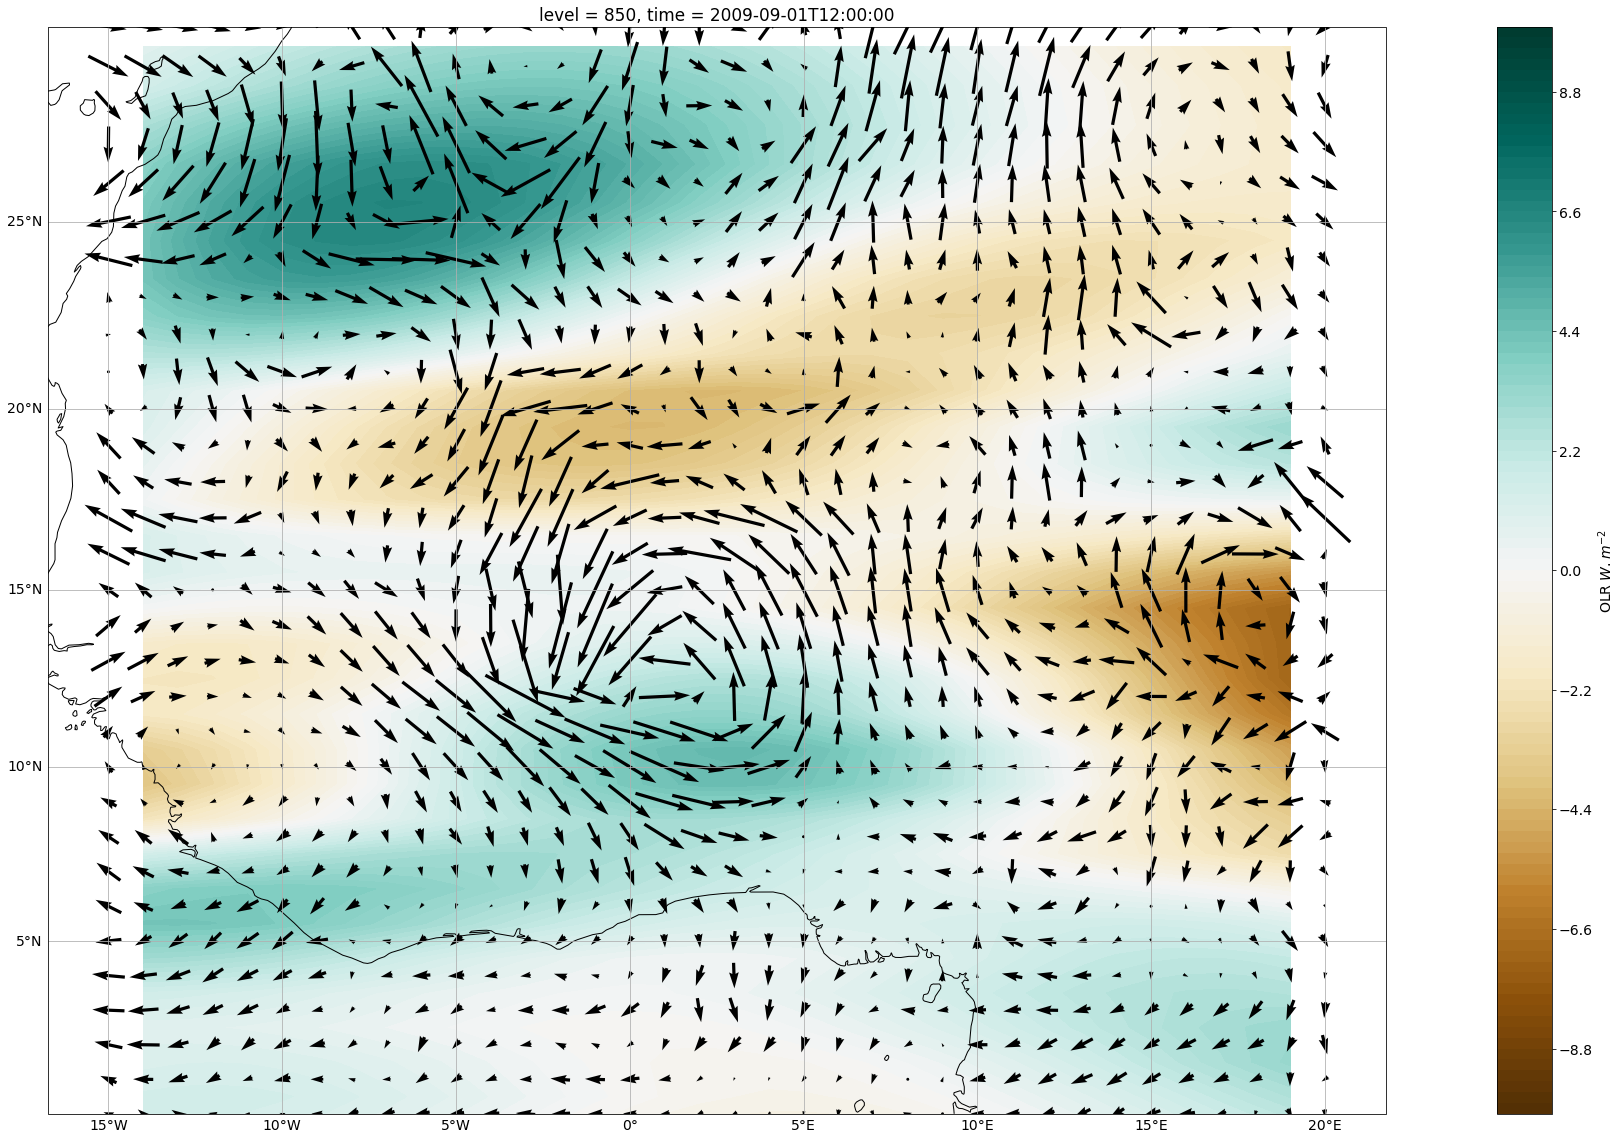

In [35]:
#####################################################################################
colorbar = {'label': 'OLR $W.m^{-2}$',
            'orientation': 'vertical' ,
            'extend' : 'both'}

fig, axis = plt.subplots( 1, 1, 
    figsize=(40,20), subplot_kw={'projection': map_proj})

_ds_anom_OLR['OLR_MRG'].plot.contourf(ax=axis, levels = 101, vmin = vmin, vmax = vmax,
                    transform=ccrs.PlateCarree(),
                    cmap=cmap ,
                    cbar_kwargs=colorbar)


ds.isel(level=1).plot.quiver(x="longitude", y="latitude", u="u_ano", v="v_ano",
                                    transform=ccrs.PlateCarree(), ax=axis, 
                                    scale = 200)

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.show()

## à 200 hPA

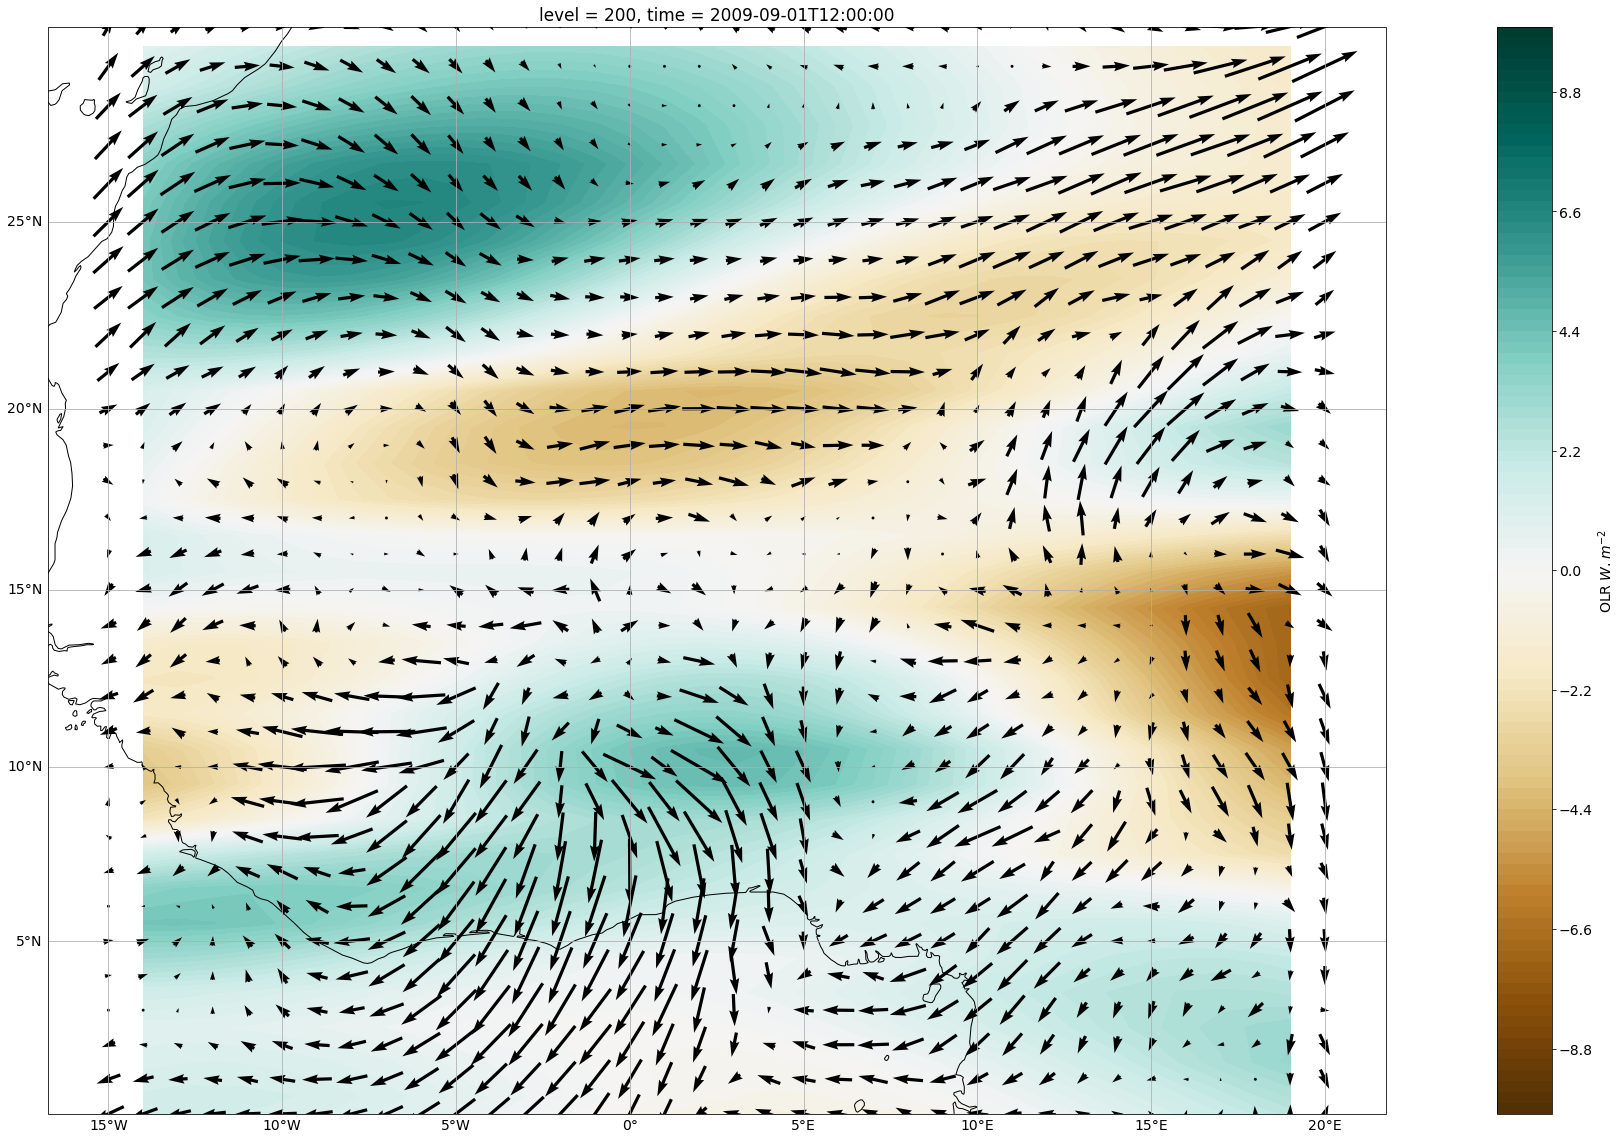

In [36]:
#####################################################################################
colorbar = {'label': 'OLR $W.m^{-2}$',
            'orientation': 'vertical' ,
            'extend' : 'both'}

fig, axis = plt.subplots( 1, 1, 
    figsize=(40,20), subplot_kw={'projection': map_proj})

_ds_anom_OLR['OLR_MRG'].plot.contourf(ax=axis, levels = 101, vmin = vmin, vmax = vmax,
                    transform=ccrs.PlateCarree(),
                    cmap=cmap ,
                    cbar_kwargs=colorbar)


ds.isel(level=0).plot.quiver(x="longitude", y="latitude", u="u_ano", v="v_ano",
                                    transform=ccrs.PlateCarree(), ax=axis, 
                                    scale = 400)

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.show()

# EIG

# à 850 hPa

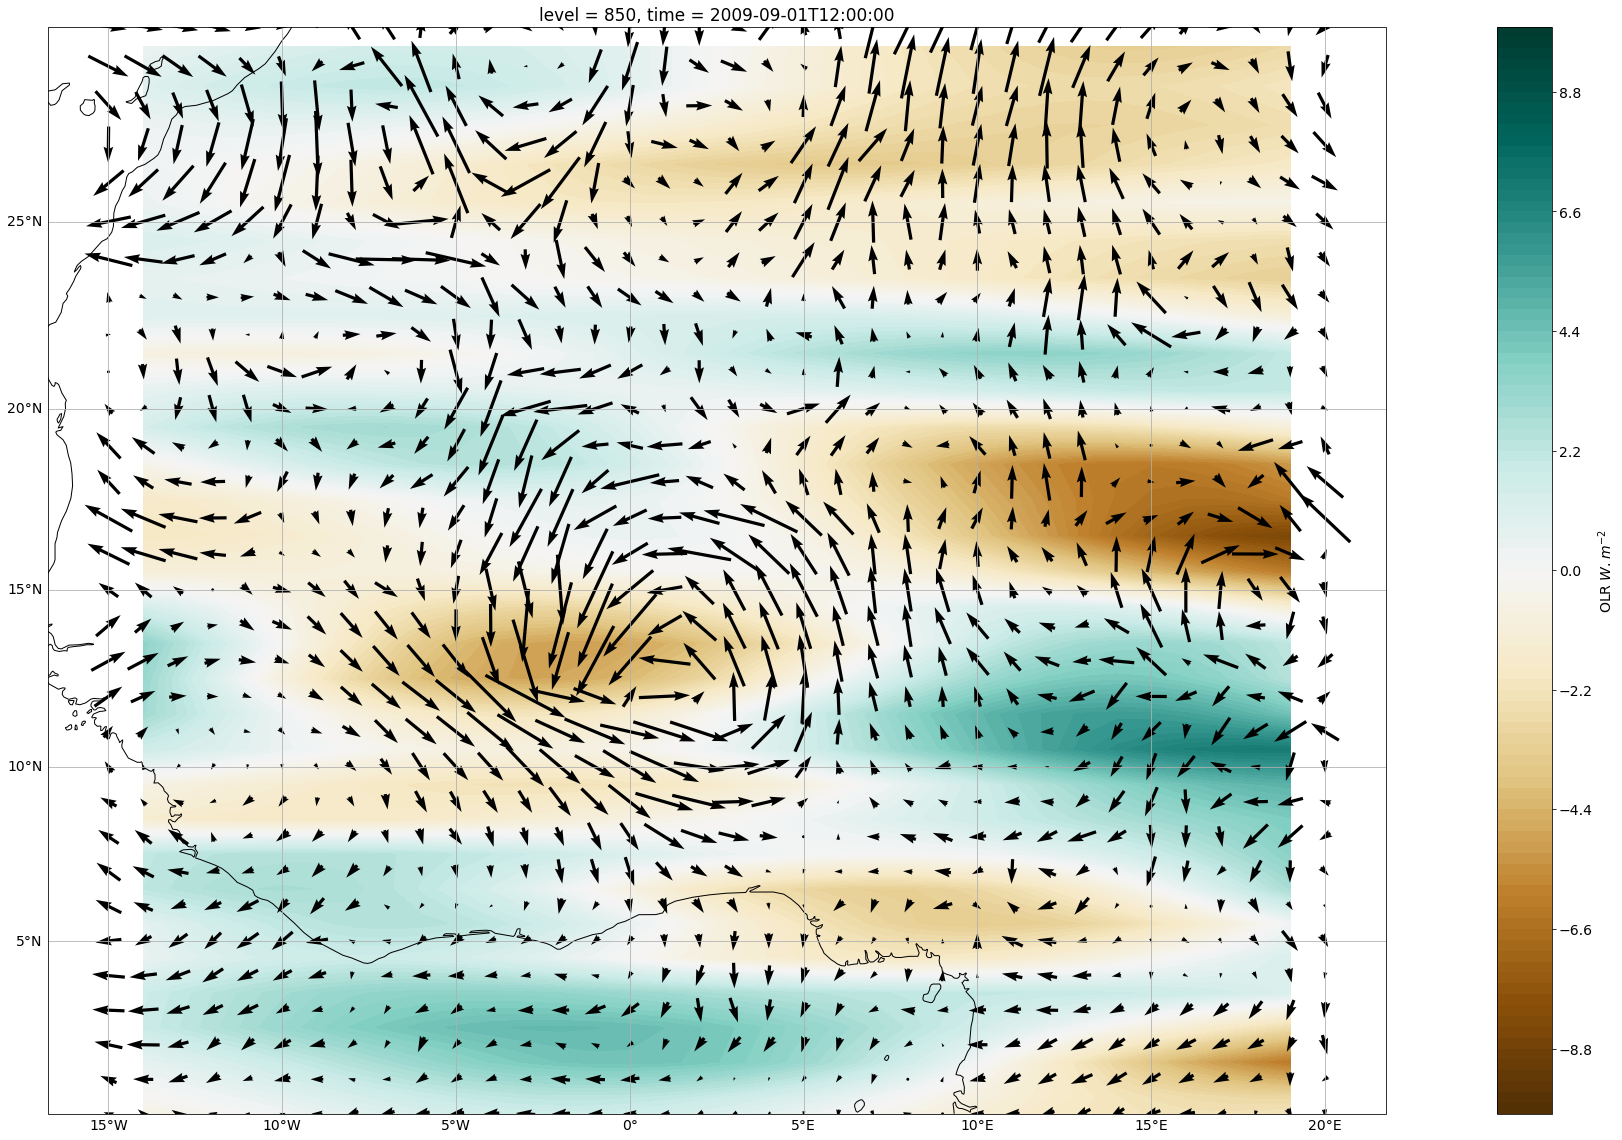

In [37]:
#####################################################################################
colorbar = {'label': 'OLR $W.m^{-2}$',
            'orientation': 'vertical' ,
            'extend' : 'both'}

fig, axis = plt.subplots( 1, 1, 
    figsize=(40,20), subplot_kw={'projection': map_proj})

_ds_anom_OLR['OLR_EIG'].plot.contourf(ax=axis, levels = 101, vmin = vmin, vmax = vmax,
                    transform=ccrs.PlateCarree(),
                    cmap=cmap ,
                    cbar_kwargs=colorbar)


ds.isel(level=1).plot.quiver(x="longitude", y="latitude", u="u_ano", v="v_ano",
                                    transform=ccrs.PlateCarree(), ax=axis, 
                                    scale = 200)

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.show()

# à 200 hPA

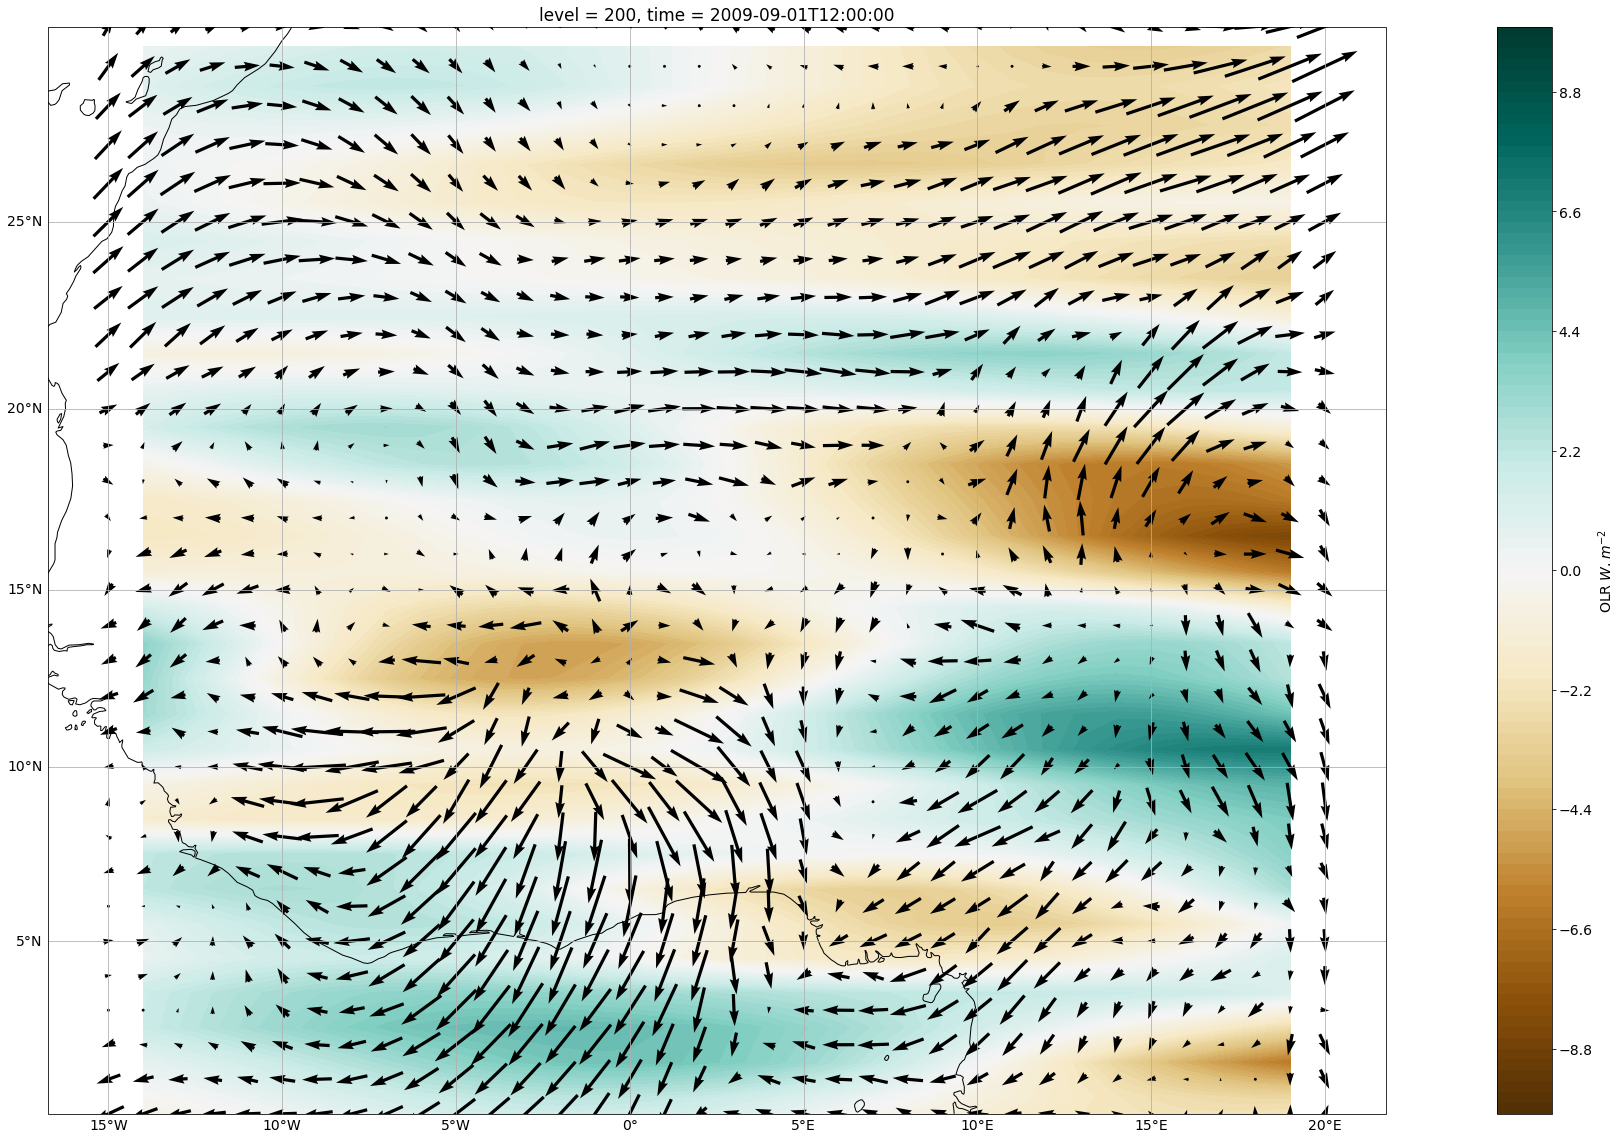

In [38]:
#####################################################################################
colorbar = {'label': 'OLR $W.m^{-2}$',
            'orientation': 'vertical' ,
            'extend' : 'both'}

fig, axis = plt.subplots( 1, 1, 
    figsize=(40,20), subplot_kw={'projection': map_proj})

_ds_anom_OLR['OLR_EIG'].plot.contourf(ax=axis, levels = 101, vmin = vmin, vmax = vmax,
                    transform=ccrs.PlateCarree(),
                    cmap=cmap ,
                    cbar_kwargs=colorbar)


ds.isel(level=0).plot.quiver(x="longitude", y="latitude", u="u_ano", v="v_ano",
                                    transform=ccrs.PlateCarree(), ax=axis, 
                                    scale = 400)

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.show()

# WIG

# à 850 hPA

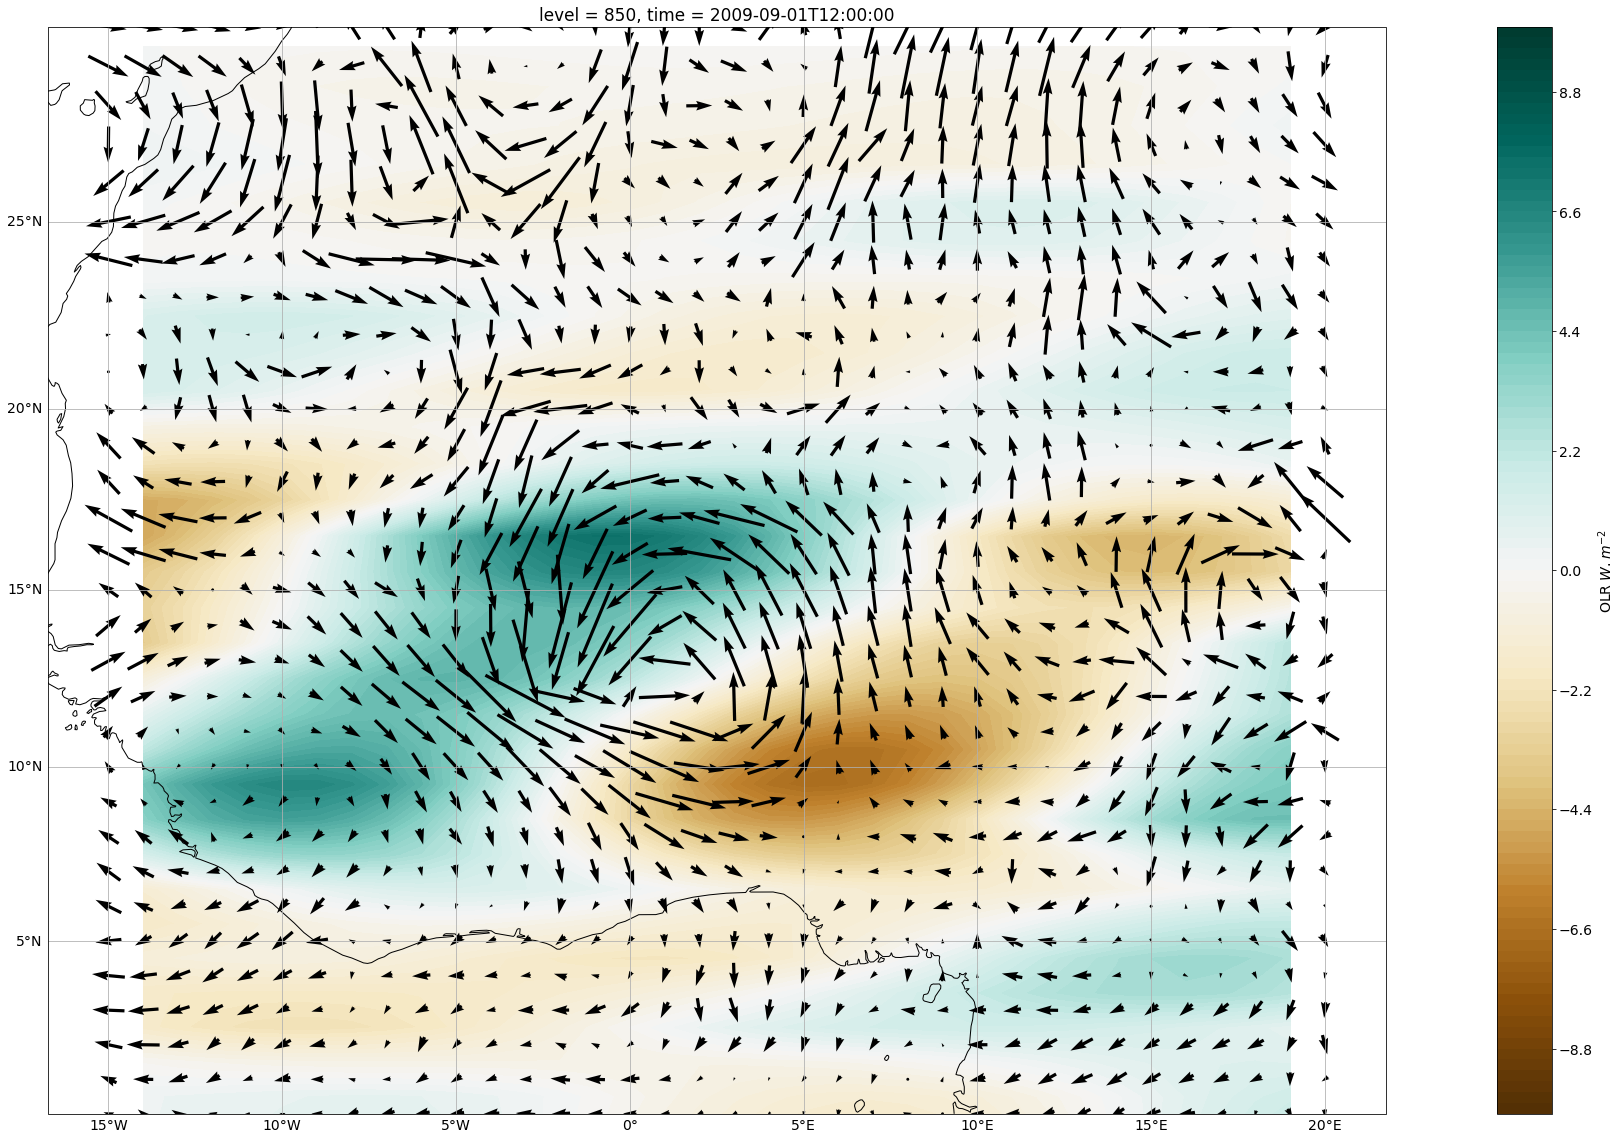

In [40]:
#####################################################################################
colorbar = {'label': 'OLR $W.m^{-2}$',
            'orientation': 'vertical' ,
            'extend' : 'both'}

fig, axis = plt.subplots( 1, 1, 
    figsize=(40,20), subplot_kw={'projection': map_proj})

_ds_anom_OLR['OLR_WIG'].plot.contourf(ax=axis, levels = 101, vmin = vmin, vmax = vmax,
                    transform=ccrs.PlateCarree(),
                    cmap=cmap ,
                    cbar_kwargs=colorbar)


ds.isel(level=1).plot.quiver(x="longitude", y="latitude", u="u_ano", v="v_ano",
                                    transform=ccrs.PlateCarree(), ax=axis, 
                                    scale = 200)

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.show()

# à 200 hPA

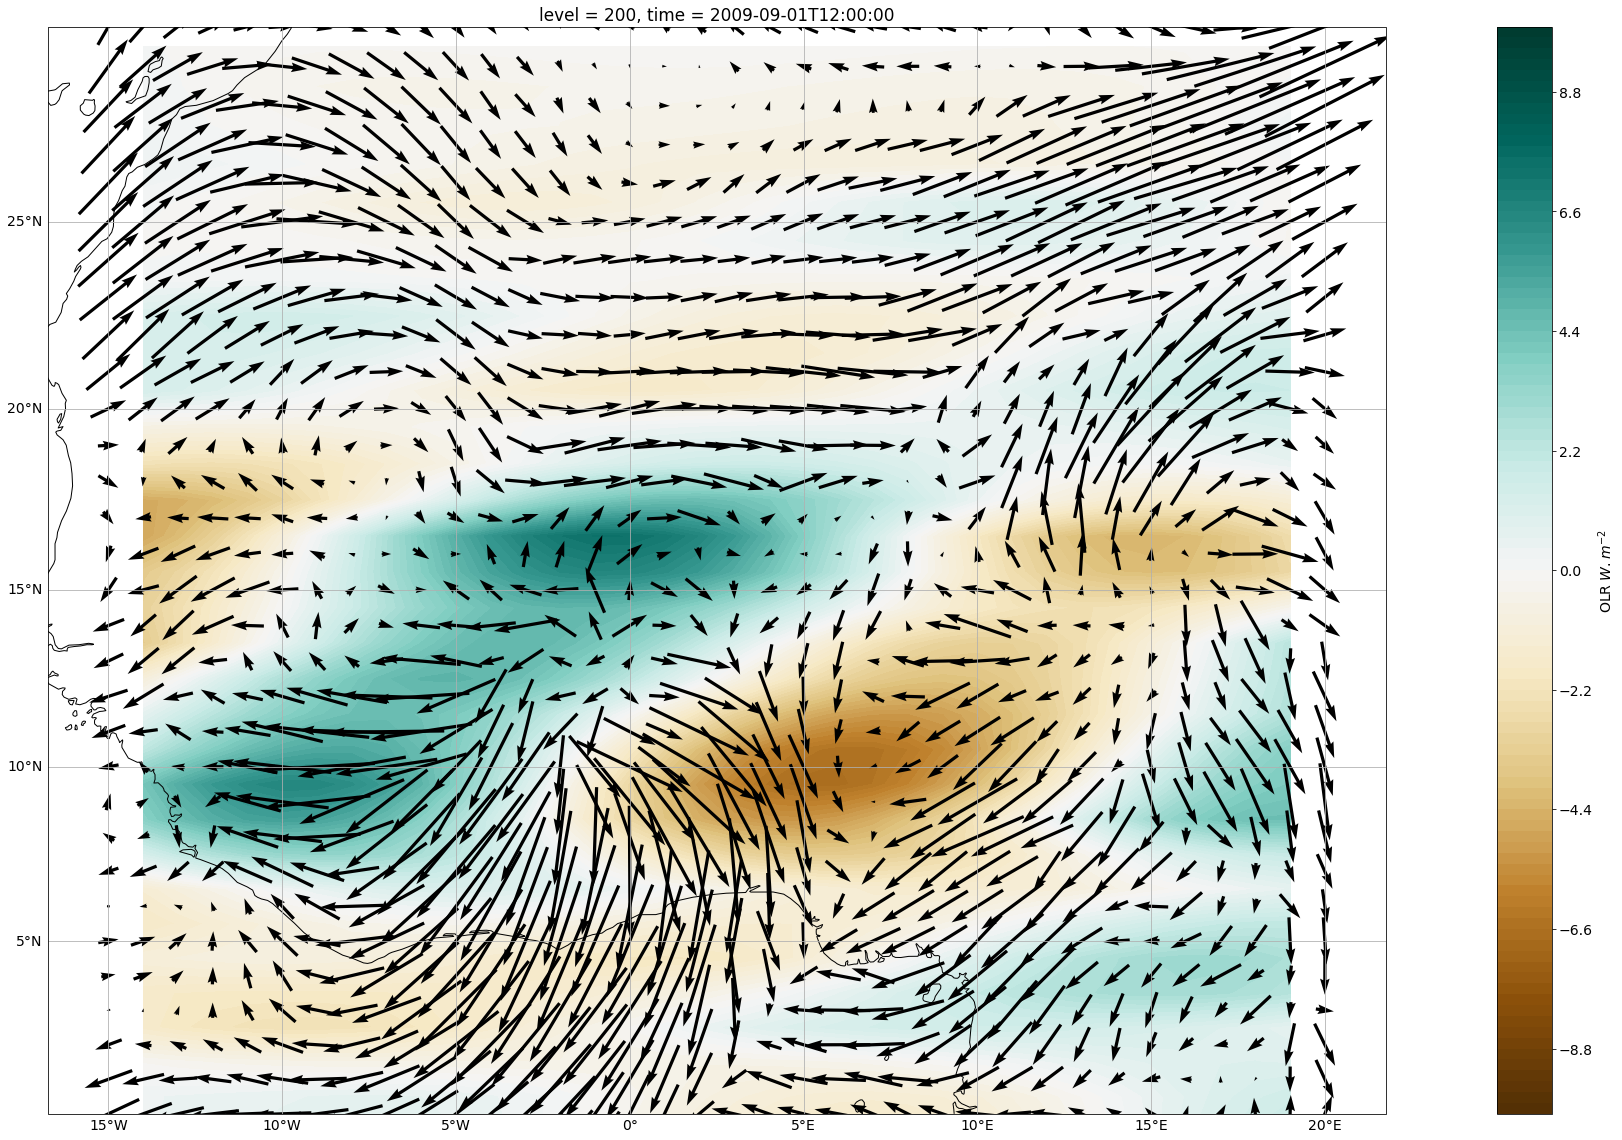

In [41]:
#####################################################################################
colorbar = {'label': 'OLR $W.m^{-2}$',
            'orientation': 'vertical' ,
            'extend' : 'both'}

fig, axis = plt.subplots( 1, 1, 
    figsize=(40,20), subplot_kw={'projection': map_proj})

_ds_anom_OLR['OLR_WIG'].plot.contourf(ax=axis, levels = 101, vmin = vmin, vmax = vmax,
                    transform=ccrs.PlateCarree(),
                    cmap=cmap ,
                    cbar_kwargs=colorbar)


ds.isel(level=0).plot.quiver(x="longitude", y="latitude", u="u_ano", v="v_ano",
                                    transform=ccrs.PlateCarree(), ax=axis, 
                                    scale = 200)

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.show()